<h2 style="color:blue" align="center">Post Training Integer Quantization Tutorial</h2>

Integer quantization is a technique that optimizes machine learning models by converting 32-bit floating-point values—like weights and activation outputs—into 8-bit integers. This reduces the model's size and boosts inference speed, which is especially useful for resource-constrained devices like microcontrollers. Additionally, some hardware accelerators, such as the Edge TPU, require models in integer format.

In this tutorial, you’ll train an MNIST model from scratch, convert it to a LiteRT format, and apply post-training quantization. You’ll then evaluate the performance of the quantized model and compare its accuracy with the original floating-point version.

There are different levels of quantization available. In this tutorial, you’ll use full integer quantization, which converts all model weights and activation outputs to 8-bit integers. Other quantization methods may retain some floating-point values.

For more information on quantization techniques, check out the resources on LiteRT model optimization.

In [27]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.18.0


In [28]:
%matplotlib inline

## Mnist Data

In [29]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [30]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

<h3 style='color:purple'>Model Building</h3>

In [31]:
# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [32]:
# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=10,
  validation_data=(test_images, test_labels)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8585 - loss: 0.5005 - val_accuracy: 0.9612 - val_loss: 0.1389
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9636 - loss: 0.1299 - val_accuracy: 0.9749 - val_loss: 0.0876
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9755 - loss: 0.0837 - val_accuracy: 0.9786 - val_loss: 0.0738
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9800 - loss: 0.0700 - val_accuracy: 0.9787 - val_loss: 0.0671
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9830 - loss: 0.0587 - val_accuracy: 0.9801 - val_loss: 0.0623
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9857 - loss: 0.0482 - val_accuracy: 0.9818 - val_loss: 0.0565
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9858 - loss: 0.0466 - val_accuracy: 0.9825 - val_loss: 0.0583
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9891 - loss: 0.0380 

## Convert to a LiteRT model

Now you can convert the trained model to LiteRT format using the LiteRT Converter, and apply varying degrees of quantization.

Beware that some versions of quantization leave some of the data in float format. So the following sections show each option with increasing amounts of quantization, until we get a model that's entirely int8 or uint8 data. (Notice we duplicate some code in each section so you can see all the quantization steps for each option.)

First, here's a converted model with no quantization:



In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpqm2yp0zc/assets


Saved artifact at '/tmp/tmpqm2yp0zc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135220458921936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458922512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458915792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458924240: TensorSpec(shape=(), dtype=tf.resource, name=None)


It's now a LiteRT model, but it's still using 32-bit float values for all parameter data.

### Convert using dynamic range quantization
Now let's enable the default optimizations flag to quantize all fixed parameters (such as weights):

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpkpanbfzh/assets


Saved artifact at '/tmp/tmpkpanbfzh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135220458921936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458922512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458915792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458924240: TensorSpec(shape=(), dtype=tf.resource, name=None)


The model is now a bit smaller with quantized weights, but other variable data is still in float format.


### Convert using float fallback quantization
To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a RepresentativeDataset. This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.) To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.




In [35]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpvtdsgl0_/assets


Saved artifact at '/tmp/tmpvtdsgl0_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135220458921936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458922512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458915792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458924240: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Now all weights and variable data are quantized, and the model is significantly smaller compared to the original LiteRT model.

However, to maintain compatibility with applications that traditionally use float model input and output tensors, the LiteRT Converter leaves the model input and output tensors in float:

In [36]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


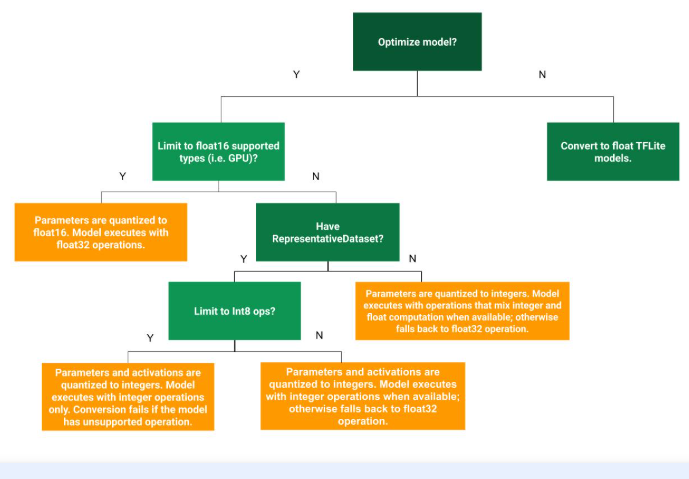

While that approach improves compatibility in general, it won’t work with hardware that only supports integer operations—like the Edge TPU.

Also, if LiteRT doesn’t have a quantized version of a specific operation, it may keep that operation in floating-point format. This helps ensure the model conversion succeeds and still results in a smaller, faster model. However, such a model won’t be fully compatible with integer-only devices. (In this MNIST example, every operation does have a quantized version.)

To build a fully integer-only model from start to finish, you'll need to include a few additional parameters...

### Convert using integer-only quantization
To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:

In [37]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpobhfpi6m/assets


Saved artifact at '/tmp/tmpobhfpi6m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135220458921936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458922512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458915792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135220458924240: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


The internal quantization remains the same as above, but you can see the input and output tensors are now integer format:

In [38]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Now you have an integer quantized model that uses integer data for the model's input and output tensors, so it's compatible with integer-only hardware such as the Edge TPU.

##Save the models as files
You'll need a .tflite file to deploy your model on other devices. So let's save the converted models to files and then load them when we run inferences below.

In [41]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24792

###Run the LiteRT models
Now we'll run inferences using the LiteRT Interpreter API to compare the model accuracies.

First, we need a function that runs inference with a given model and images, and then returns the predictions:

In [42]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

##Test the models on one image
Now we'll compare the performance of the float model and quantized model:

tflite_model_file is the original LiteRT model with floating-point data.
tflite_model_quant_file is the last model we converted using integer-only quantization (it uses uint8 data for input and output).
Let's create another function to print our predictions:




In [43]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

Now test the float model:

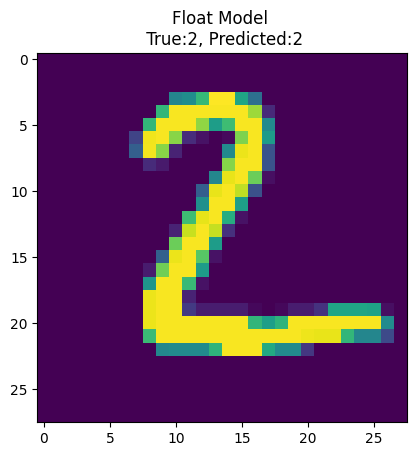

In [44]:
test_model(tflite_model_file, test_image_index, model_type="Float")

Test Quantized Model

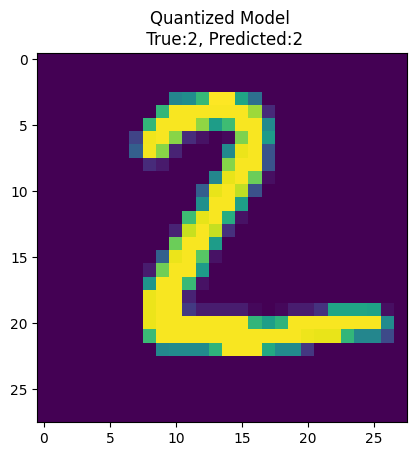

In [45]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

## Evaluate the models on all images
Now let's run both models using all the test images we loaded at the beginning of this tutorial:

In [46]:
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [47]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 98.1800% (Number of test samples=10000)


In [48]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 98.1800% (Number of test samples=10000)


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\dhava\AppData\Local\Temp\tmpqnsx4bvx\assets


INFO:tensorflow:Assets written to: C:\Users\dhava\AppData\Local\Temp\tmpqnsx4bvx\assets


In [ ]:
len(tflite_qaware_model)

82376

In [ ]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)